In [90]:
import os
import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

from copy import deepcopy
from collections import namedtuple

from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

import pydrake
from pydrake.all import (
    AngleAxis,
    CommonSolverOption,
    MathematicalProgram,
    MakeSolver,
    RandomGenerator,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    GurobiSolver,
    Solve,
    SolverOptions,
    VPolytope,
    MixedIntegerRotationConstraintGenerator,
    IntervalBinning,
    UniformlyRandomRotationMatrix
)

In [91]:
import meshcat
import meshcat.geometry as meshcat_geom

if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://lab.protos.us.to"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

Meshcat url:  http://lab.protos.us.to:7010/static/


In [97]:
'''
Minimal simple grammar that hopefully enables MIP-based MAP
scene parsing.

Spatial scene grammar definition: each node has:
- a pose `tf` \in SE(3), represented with a RigidTransform
- a shape, as a Meshcat-visualizable geometry.

Nodes can choose which child to produce by following:
- an AND rule, producing all possible children.
- an OR rule, producing one child out of the set of possible children.
- a GEOMETRIC_SET rule, producing up to N children.

For each child, if it is produced, nodes can produce the child:
- With xyz:
   - In a uniform xyz window offset relative to parent
- With rotation:
   - Unconstrained
   - In uniform angle window, rotating around specified axis in parent frame.

A node subclasses a Node type. They should be initializable with zero
arguments.
'''

# Axis-aligned, for now. Can generalize to convex set.
XyzBounds = namedtuple("xyz_bounds",
    ["xyz_min", "xyz_max"]
)
# TODO: Should be able to specify the rotation offset
# in the child frame. It's currently assumed that at
# 0 rotation around the axis, the child frame lines
# up with the parent frame; and that from the child
# frame's reference, the rotation happens around the +z axis.
RotationBounds = namedtuple("rotation_bounds",
    ["axis", "min_angle", "max_angle"]
)
# child_constructor takes the child tf, and produces the child
# node 
ChildInfo = namedtuple("child_info",
    ["child_type", "child_xyz_bounds", "child_rotation_bounds"]
)

class Node(object):
    '''
        tf: RigidTransform pose of node
        observed: Boolean, whether this node is observable
        geometry: Meshcat geometry to visualize node.
    '''
    def __init__(self, tf, observed, geometry):
        self._tf = tf
        self._observed = observed
        self._geometry = geometry
        super().__init__()

    @property
    def tf(self):
        return self._tf
    
    @tf.setter
    def tf(self, tf):
        self._tf = tf
        
    @property
    def observed(self):
        return self._observed
    
    @property
    def geometry(self):
        return self._geometry
    
    def sample_children(self):
        raise NotImplementedError("Implement sample_children in subclass.")
    
    @staticmethod
    def _sample_child(parent_tf, child_info):
        # Given a ChildInfo struct, produce a randomly sampled child.
        # Sample child xyz and rotation
        xyz_offset = np.random.uniform(
            low=child_info.child_xyz_bounds.xyz_min,
            high=child_info.child_xyz_bounds.xyz_max
        )
        if child_info.child_rotation_bounds is None:
            # No constraints on child rotation; randomly
            # sample a rotation instead.
            R_offset = UniformlyRandomRotationMatrix(RandomGenerator(np.random.randint(2**31)))
        else:
            axis = child_info.child_rotation_bounds.axis
            angle = np.random.uniform(
                low=child_info.child_rotation_bounds.min_angle,
                high=child_info.child_rotation_bounds.max_angle
            )
            R_offset = RotationMatrix(AngleAxis(angle=angle, axis=axis))
        tf_offset = RigidTransform(p=xyz_offset, R=R_offset)
        tf = parent_tf.multiply(tf_offset)
        return child_info.child_type(tf=tf)


class TerminalNode(Node):
    ''' Node type that produces no children. '''
    def sample_children(self):
        return []

    
class AndNode(Node):
    ''' Node type that produces all children. '''
    def __init__(self, child_infos, **kwargs):
        assert len(child_infos) > 0
        assert all([isinstance(c, ChildInfo) for c in child_infos])
        self.child_infos = child_infos
        super().__init__(**kwargs)
    
    def sample_children(self):
        children = []
        for child_info in self.child_infos:
            children.append(self._sample_child(self.tf, child_info))
        return children

class OrNode(Node):
    ''' Node type that produces all children. '''
    def __init__(self, child_infos, child_probs, **kwargs):
        assert len(child_infos) > 0
        assert all([isinstance(c, ChildInfo) for c in child_infos])
        assert len(child_infos) == len(child_probs)
        self.child_infos = child_infos
        self.child_probs = child_probs
        super().__init__(**kwargs)
    
    def sample_children(self):
        # Pick which child will be produced.
        child_ind = np.random.choice(len(self.child_infos), p=self.child_probs)
        children = [self._sample_child(self.tf, self.child_infos[child_ind])]
        return children
        
    
class GeometricSetNode(Node):
    ''' Node type that produces all children. '''
    def __init__(self, child_infos, p, max_children, **kwargs):
        assert len(child_infos) == 1
        assert all([isinstance(c, ChildInfo) for c in child_infos])
        self.child_infos = child_infos
        self.p  = p
        self.max_children = max_children
        super().__init__(**kwargs)
    
    def sample_children(self):
        children = []
        # Repeatedly spawn
        n = min(np.random.geometric(self.p), self.max_children)
        for k in range(n):
            children.append(self._sample_child(self.tf, self.child_infos[0]))
        return children
    
def sample_tree(root_type, root_tf):
    # Sample an unconditioned tree from this grammar.
    tree = nx.DiGraph()
    root = root_type(tf=root_tf)
    tree.add_node(root)
    node_queue = [root]

    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        # Ask node to sample its children.
        children = parent.sample_children()
        for child in children:
            tree.add_node(child)
            tree.add_edge(parent, child)
            node_queue.append(child)

    return tree

def get_observed_nodes(tree):
    # Given a scene tree (nx.DiGraph) and a list of observed
    # node type names (list of strings), pulls out only nodes
    # in the  tree with matching type into a list of Nodes.
    return [n for n in tree if n.observed is True]

def get_tree_root(tree):
    # Assumes tree structure; might infinite loop otherwise.
    root = list(tree.nodes)[0]
    while len(list(tree.predecessors(root))) > 0:
        root = list(tree.predecessors(root))[0]
    return root
        
def draw_tree(tree, vis, prefix=""):
    # Given a scene tree (nx.DiGraph), draw it in the
    # specified meshcat visualizer.
    
    # Draw the scene geometry recursively.
    root = get_tree_root(tree)
    name_prefix = prefix + "scene"
    vis[name_prefix].delete()
    name_management = {}
    def draw_subtree(node, parent_tf, name_prefix):
        base_name = node.__class__.__name__
        if base_name not in name_management.keys():
            name = base_name + "_%03d" % 0
            name_management[base_name] = 1
        else:
            name = base_name + "_%03d" % name_management[base_name]
            name_management[base_name] += 1
        name = name_prefix + "/%s" % name
        
        if node.geometry is not None:
            color = 0xffffff
            alpha = 0.75
            vis[name].set_object(
                node.geometry,
                meshcat_geom.MeshToonMaterial(color=color, opacity=alpha, transparent=(alpha != 1.))
            )
            rel_tf = parent_tf.inverse().multiply(node.tf)
            vis[name].set_transform(rel_tf.GetAsMatrix4())
        
        for child in tree.successors(node):
            draw_subtree(child, node.tf, name)
    draw_subtree(root, root.tf, name_prefix)
    
    # Draw the tree structure.
    tree_prefix = prefix + "tree"
    vis[tree_prefix].delete()
    k = 0
    for node in tree.nodes:
        name = tree_prefix + "/" + node.__class__.__name__ + "_%03d" % k
        k += 1
        # Draw node as randomly colored sphere
        color = random.randint(0, 0xFFFFFF)
        alpha = 0.5
        vis[name].set_object(
            meshcat_geom.Sphere(0.05),
            meshcat_geom.MeshToonMaterial(color=color, opacity=alpha, transparent=(alpha != 1.))
        )
        vis[name].set_transform(node.tf.GetAsMatrix4())
        # Draw children
        verts = []
        for child in tree.successors(node):
            # Draw link to child
            verts.append(node.tf.translation()),
            verts.append(child.tf.translation())
        if len(verts) > 0:
            verts = np.vstack(verts).T
            vis[name + "_child_connections"].set_object(
                meshcat_geom.Line(meshcat_geom.PointsGeometry(verts),
                                  meshcat_geom.LineBasicMaterial(linewidth=50, color=color)))

In [109]:
class Sink(AndNode):
    def __init__(self, tf):
        child_infos = [
            ChildInfo(
                child_type=Plates,
                child_xyz_bounds=XyzBounds(np.array([0., 0., 0.]), np.array([0., 0., 0.])),
                child_rotation_bounds=RotationBounds(np.array([1., 0., 0.]), 0., 0.)
            )
        ]
        geometry = None
        super().__init__(
            child_infos=child_infos,
            tf=tf,
            geometry=geometry,
            observed=False
        )

class Plates(GeometricSetNode):
    def __init__(self, tf):
        child_infos = [
            ChildInfo(
                child_type=Plate,
                child_xyz_bounds=XyzBounds(np.array([0., 0., 0.05]), np.array([1., 1., 0.05])),
                child_rotation_bounds=RotationBounds(np.array([0., 0., 1.]), -np.pi, np.pi)
            )
        ]
        geometry = None
        super().__init__(
            child_infos=child_infos,
            p=0.3,
            max_children=3,
            tf=tf,
            geometry=geometry,
            observed=False
        )

class Plate(OrNode):
    def __init__(self, tf):
        # Either spawns another plate on top, or nothing.
        child_infos = [
            ChildInfo(
                child_type=Plate,
                child_xyz_bounds=XyzBounds(np.array([-0.01, -0.01, 0.1]), np.array([0.01, 0.01, 0.1])),
                child_rotation_bounds=RotationBounds(np.array([0., 0., 1.]), -np.pi, np.pi)
            ),
            ChildInfo(
                child_type=Null,
                child_xyz_bounds=XyzBounds(np.zeros(3), np.zeros(3)),
                child_rotation_bounds=RotationBounds(np.array([0., 0., 1.]), 0., 0.)
            ),
        ]
        child_probs = np.array([0.5, 0.5])
        geometry = meshcat_geom.Box([0.2, 0.2, 0.1])
        super().__init__(
            child_infos=child_infos,
            child_probs=child_probs,
            tf=tf,
            geometry=geometry,
            observed=True
        )

class Null(TerminalNode):
    def __init__(self, tf):
        geometry = None
        super().__init__(
            tf=tf,
            geometry=geometry,
            observed=False
        )

root_tf = RigidTransform()

Sink(tf = RigidTransform())
Plates(tf = RigidTransform())
Plate(tf = RigidTransform())
Null(tf = RigidTransform())

In [110]:
np.random.seed(43)
random.seed(43)
observed_tree = sample_tree(Sink, root_tf)
observed_nodes = get_observed_nodes(observed_tree)
for n in observed_tree.nodes:
    print(n, n.tf.translation(), n.tf.rotation())
draw_tree(observed_tree, vis, prefix="gt/")

<__main__.Sink object at 0x7fa3456b1be0> [0. 0. 0.] RotationMatrix([
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [0.0, 0.0, 1.0],
])
<__main__.Plates object at 0x7fa3456b1710> [0. 0. 0.] RotationMatrix([
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [0.0, 0.0, 1.0],
])
<__main__.Plate object at 0x7fa3456b1d30> [0.85913749 0.66609021 0.05      ] RotationMatrix([
  [-0.9834294614954038, 0.18129118639045888, 0.0],
  [-0.18129118639045888, -0.9834294614954038, 0.0],
  [0.0, 0.0, 1.0],
])
<__main__.Plate object at 0x7fa3456b1dd8> [0.7337483  0.39495002 0.05      ] RotationMatrix([
  [0.02777518056046738, 0.999614195249764, 0.0],
  [-0.999614195249764, 0.02777518056046738, 0.0],
  [0.0, 0.0, 1.0],
])
<__main__.Plate object at 0x7fa34a04c630> [0.85091453 0.67024778 0.15      ] RotationMatrix([
  [-0.5626564152165412, -0.8266908481504264, 0.0],
  [0.8266908481504264, -0.5626564152165412, 0.0],
  [0.0, 0.0, 1.0],
])
<__main__.Plate object at 0x7fa34634c4e0> [0.74091505 0.38828201 0.15      ] RotationMatr

# MIP Scene Parsing for this grammar

We're given the grammar description (implicit in the node definitions); can we recover a MAP parse tree?

Same logic as previous MIP parsing: create the super tree for the grammar (cutting off recursive rules at a max recursion depth), and create decision variables for each possible node location and activation. Impose feasibility constraints on each parent/child pair:
- Child activation implies parent activation
- If the parent is an AND node and is active, all children are active.
- If the parent is an OR node and is active, exactly one child is active.

Impose additional symmetry breaking constraints:
- Prefer children activate in left-to-right order, and are assigned ascending poses in the x coordinate (symmetry breaking).


Super tree has 23 nodes


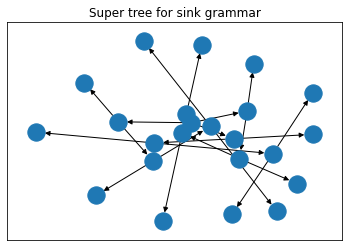

In [100]:
def make_super_tree(root_node_type, max_recursion_depth=5):
    # Forms a graph of nodes for which any actual sampled tree would be a subgraph.
    # (TF's are all set to 0.)
    tree = nx.DiGraph()
    root = root_node_type(tf = RigidTransform())
    root.__recursion_depth = 0
    tree.add_node(root)
    node_queue = [root]
    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        if isinstance(parent, (AndNode, OrNode)):
            maximal_children = [ci.child_type for ci in parent.child_infos]
        elif isinstance(parent, GeometricSetNode):
            maximal_children = [parent.child_infos[0].child_type for k in range(parent.max_children)]
        elif isinstance(parent, TerminalNode):
            maximal_children = []
        else:
            raise ValueError(type(parent))

        for child_type in maximal_children:
            child = child_type(tf = RigidTransform())
            child.__recursion_depth = parent.__recursion_depth + 1
            if child.__recursion_depth <= max_recursion_depth:
                tree.add_node(child)
                tree.add_edge(parent, child)
                node_queue.append(child)
    return tree

super_tree = make_super_tree(Sink)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for sink grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

In [116]:
def infer_mle_tree(root_node_type, root_tf, observed_nodes, verbose=False):
    super_tree = make_super_tree(root_node_type)
    observed_nodes = deepcopy(observed_nodes)

    prog = MathematicalProgram()

    # Every node gets a binary variable to indicate
    # whether it's active or node. This is equivalent to a
    # binary variable on the incoming edge for the node.
    active_vars = prog.NewBinaryVariables(len(super_tree.nodes), "nodes_active")
    for k, node in enumerate(super_tree.nodes):
        node.active = active_vars[k]

    # Every node gets an optimized pose.
    mip_rot_gen = MixedIntegerRotationConstraintGenerator(
        approach = MixedIntegerRotationConstraintGenerator.Approach.kBilinearMcCormick,
        num_intervals_per_half_axis=2,
        interval_binning = IntervalBinning.kLogarithmic
    )
    for node_k, node in enumerate(super_tree.nodes):
        node.R_optim = prog.NewContinuousVariables(3, 3, "%d_t" % (node_k))
        mip_rot_gen.AddToProgram(node.R_optim, prog)
        node.t_optim = prog.NewContinuousVariables(3, "%d_t" % (node_k))
        

    # Constraint root node to have the grammar's root position.
    root_node = get_tree_root(super_tree)
    prog.AddBoundingBoxConstraint(
        root_tf.translation(), root_tf.translation(),
        root_node.t_optim
    )
    R_target_flat = root_tf.rotation().matrix().flatten()
    prog.AddBoundingBoxConstraint(
        R_target_flat, R_target_flat,
        root_node.R_optim.flatten()
    )
    
    ## For each node in the super tree, add relationships between the parent
    ## and that node.
    for parent_node in super_tree:
        children = list(super_tree.successors(parent_node))
        child_actives = [c.active for c in children]
        parent_node.child_actives = child_actives

        # Children active requires parent active.
        for child_active in child_actives:
            prog.AddLinearConstraint(parent_node.active >= child_active)

        ## Parent/child activation relationships and symmetry breaking.
        if isinstance(parent_node, GeometricSetNode):
            # Geometric node child ordering to reduce duplicate parse: a child can
            # only be active if the previous child is also active.
            for k in range(len(child_actives) - 1):
                # child_{k+1} implies child_k
                # i.e. child_k >= child_{k+1}
                prog.AddLinearConstraint(child_actives[k] >= child_actives[k+1])

            # Child supports should be ordered, to break symmetries.
            # TODO(gizatt) Does this apply to AND nodes? I don't think so, since
            # each node under an AND node has its own distribution. But I could conceivably
            # detect "equivalent" children and break symmetries there.
            for child, next_child in zip(children[:-1], children[1:]):
                prog.AddLinearConstraint(next_child.t_optim[0] >= child.t_optim[0])

            # The geometric process we used (np.random.geometric) is only supported
            # on k=1, ..., so constrain that the # of active children must be
            # nonzero if this node is on.
            if len(child_actives) > 0:
                prog.AddLinearConstraint(sum(child_actives) >= parent_node.active)

        elif isinstance(parent_node, AndNode):
            # All children should be on if the parent node is on.
            for k in range(len(child_actives)):
                prog.AddLinearConstraint(child_actives[k] >= parent_node.active)

        elif isinstance(parent_node, OrNode):
            # Exactly one child can be on if the parent is on.
            prog.AddLinearConstraint(sum(child_actives) == parent_node.active)

        elif isinstance(parent_node, TerminalNode):
            pass
        
        else:
            raise ValueError("Unexpected node type: ", type(parent_node))
        

        ## Child location constraints relative to parent.
        for child_k, child_node in enumerate(children):
            if isinstance(parent_node, (AndNode, OrNode)):
                child_info = parent_node.child_infos[child_k]
            elif isinstance(parent_node, GeometricSetNode):
                child_info = parent_node.child_infos[0]
            else:
                raise ValueError("Unexpected node type for child info retrieval: ", type(parent_node))

            # Child translation should be within relative translation bounds of parent.
            lb_rel = child_info.child_xyz_bounds.xyz_min
            ub_rel = child_info.child_xyz_bounds.xyz_max
            # TODO: Generalize to relative position being within a convex set.
            for k in range(3):
                prog.AddLinearConstraint(child_node.t_optim[k] >= parent_node.t_optim[k] + lb_rel[k])
                prog.AddLinearConstraint(child_node.t_optim[k] <= parent_node.t_optim[k] + ub_rel[k])

            # Short-circuit if the rotation is unconstrained.
            if child_info.child_rotation_bounds is not None:
                axis = child_info.child_rotation_bounds.axis
                min_angle = child_info.child_rotation_bounds.min_angle
                max_angle = child_info.child_rotation_bounds.max_angle
                assert min_angle <= max_angle
                if min_angle == max_angle:
                    # Short-circuit if the rotation is exactly constraint to parent rotation.
                    for i in range(3):
                        for j in range(3):
                            prog.AddLinearEqualityConstraint(child_node.R_optim[i, j] == parent_node.R_optim[i, j])
                else:
                    # Child rotation should be within a relative rotation of the parent around
                    # the specified axis, and the axis should *not* be rotated between the
                    # parent and child frames. This is similar to the revolute joint constraints
                    # used by Hongkai Dai in his global IK formulation.
                    # (1): The direction of the rotation axis doesn't change between
                    # parent and child frames.
                    parent_view_of_axis_in_world = parent_node.R_optim.dot(axis)
                    # The axis around which the child rotates (in its own frame) is
                    # assumed to be the +z axis.
                    axis_in_child = np.array([0., 0., 1.])
                    child_view_of_axis_in_world = child_node.R_optim.dot(axis_in_child)
                    for k in range(3):
                        prog.AddLinearEqualityConstraint(
                            parent_view_of_axis_in_world[k] == child_view_of_axis_in_world[k]
                        )
                    
                    # Short-circuit if there is no rotational constraint other than axis alignment.
                    if max_angle - min_angle < 2.*np.pi:
                        # (2): Eq(10) in the global IK paper. Following implementation in
                        # https://github.com/RobotLocomotion/drake/blob/master/multibody/inverse_kinematics/global_inverse_kinematics.cc
                        # First generate a vector normal to the rotation axis via cross products.
                        v_c = np.cross(axis, np.array([0., 0., 1.]))
                        if np.linalg.norm(v_c) <= np.sqrt(2)/2:
                            # Axis is too close to +z; try a different axis.
                            v_c = np.cross(axis, np.array([0., 1., 0.]))
                        v_c = v_c / np.linalg.norm(v_c)
                        # TODO: Hongkai uses multiple perpendicular vectors. Worth a try?

                        # Translate into a symmetric bound by finding a rotation to
                        # "center" us in the bound region, and the symmetric bound size alpha.
                        # -alpha <= theta - (a+b)/2 <= alpha
                        # where alpha = (b-a) / 2
                        alpha = (max_angle - min_angle) / 2.
                        offset_angle = (max_angle + min_angle) / 2.
                        R_offset = RotationMatrix(AngleAxis(axis, offset_angle)).matrix()
                        # |R_WC*R_CJc*v - R_WP * R_PJp * R(k,(a+b)/2)*v | <= 2*sin (α / 2) in
                        # global ik code; for us, I'm assuming the joint frames are aligned with
                        # the body frames, so R_CJc and R_PJp are identitiy.
                        lorentz_bound = 2 * np.sin(alpha / 2.)
                        vector_diff = (
                            child_node.R_optim * v - 
                            parent_node.R_optim * rotmat_joint_offset * v
                        )
                        # TODO: Linear approx?
                        prog.AddLorentzConeConstraint(np.r_(lorentz_bound, vector_diff))

    # For each observed node, add a binary variable for each possible
    # correspondence to a node in the observed set, where an active correspondence
    # forces the corresponded node to be the same position as the observed node.
    for n in super_tree:
        # (first prep some bookkeeping)
        n.outgoings = []
    for observed_node in observed_nodes:
        possible_sources = [n for n in super_tree if type(n) == type(observed_node)]
        source_actives = prog.NewBinaryVariables(len(possible_sources), observed_node.__class__.__name__ + "_sources")

        # Store these variables
        observed_node.source_actives = source_actives
        for k, n in enumerate(possible_sources):
            n.outgoings.append(source_actives[k])

        # Each observed node needs exactly one explaining input.
        prog.AddLinearEqualityConstraint(sum(source_actives) == 1)

        for k, node in enumerate(possible_sources):
            M = 10. # Should upper bound positional error in any single dimension
            # When correspondence is active, force the node to match the observed node.
            # Otherwise, it can vary within a big M of the observed node.
            obs_t = observed_node.tf.translation()
            obs_R = observed_node.tf.rotation().matrix()
            for i in range(3):
                prog.AddLinearConstraint(node.t_optim[i] <= obs_t[i] + 1E-6 + (1. - source_actives[k]) * M)
                prog.AddLinearConstraint(node.t_optim[i] >= obs_t[i] - 1E-6 - (1. - source_actives[k]) * M)
            for i in range(3):
                for j in range(3):
                    prog.AddLinearConstraint(node.R_optim[i, j] <= obs_R[i, j] + 1E-6 + (1. - source_actives[k]) * M)
                    prog.AddLinearConstraint(node.R_optim[i, j] >= obs_R[i, j] - 1E-6 - (1. - source_actives[k]) * M)

    # Go back and make sure no node in the super tree is being used
    # to explain more than one observed node, and that the "observed"
    # nodes are only active if they are explaining something.
    # TODO(gizatt) These constraints are a little frustrating: without
    # them, the parsing likes to hallucinate unnecessary hidden nodes
    # since adding them increases the tree likelihood (since the net log-prob
    # of adding a new node is positive due to concentrated densities).
    # It makes me feel like I'm doing something fundamentally wrong, like using
    # total model prob to do model comparisons between models of different size.
    for node in super_tree:
        if node.observed:
            if len(node.outgoings) > 0:
                prog.AddLinearConstraint(sum(node.outgoings) <= 1)
                prog.AddLinearConstraint(node.active == sum(node.outgoings))
            else:
                # Never observed this type in the scene, so this node can't be active.
                prog.AddLinearConstraint(node.active == 0)
            
    # Finally, build the objective.
    entropy = 0.
    for parent_node in super_tree:
        # For the discrete states, do maximum likelihood.
        children = list(super_tree.successors(parent_node))
        if isinstance(parent_node, (AndNode, TerminalNode)):
            pass
        elif isinstance(parent_node, OrNode):
            # Binary variables * log of probabilities.
            for p, child in zip(parent_node.child_probs, children):
                prog.AddLinearCost(-np.log(p) * child.active)
        elif isinstance(parent_node, GeometricSetNode):
            p = parent_node.p
            for child in children:
                prog.AddLinearCost(-np.log(1.-p) * child.active)            
        else:
            raise ValueError("Unexpected node in cost assembly: ", type(parent_node))

        # TODO: Continuous cost?

    solver = GurobiSolver()
    options = SolverOptions()
    logfile = "/tmp/gurobi.log"
    os.system("rm %s" % logfile)
    options.SetOption(solver.id(), "LogFile", logfile)
    if verbose:
        print("Num vars: ", prog.num_vars())
        print("Num constraints: ", sum([c.evaluator().num_constraints() for c in prog.GetAllConstraints()]))
    result = solver.Solve(prog, None, options)
    if verbose:
        print("Optimization success?: ", result.is_success())
        print("Logfile: ")
        with open(logfile) as f:
            print(f.read())
    TreeInferenceResults = namedtuple("TreeInferenceResults", ["optim_result", "super_tree", "observed_nodes"])
    return TreeInferenceResults(result, super_tree, observed_nodes)
    

start_time = time.time()
inference_results = infer_mle_tree(
    Sink, root_tf, observed_nodes, verbose=True
)
elapsed = time.time() - start_time
print("Took %f secs" % elapsed)

Num vars:  23336
Num constraints:  80715
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Aug 19 15:46:02 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 57933 rows, 23336 columns and 448933 nonzeros
Model fingerprint: 0x9f94fd71
Variable types: 22839 continuous, 497 integer (497 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  Objective range  [4e-01, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 57325 rows and 22913 columns
Presolve time: 0.66s
Presolved: 608 rows, 423 columns, 4317 nonzeros
Variable types: 399 continuous, 24 integer (24 binary)
Found heuristic solution: objective 4.1790858

Explored 0 nodes (0 simplex iterations) in 0.72 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 4.17909 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.179085790677e+00, best bound 4.179085790677e+00, gap 0.0000%

Took 5

In [118]:
def get_optimized_tree(inference_results, ax=None):
    ''' From the specified inference results, extract the scene tree. '''
    # Grab that supertree from optimization
    optim_result = inference_results.optim_result
    super_tree = inference_results.super_tree
    observed_nodes = inference_results.observed_nodes

    # Sanity-check observed nodes are explained properly.
    for observed_node in observed_nodes:
        if not np.isclose(np.sum(optim_result.GetSolution(observed_node.source_actives)), 1.):
            print("WARN: observed node at %s not explained by MLE sol." % observed_node.x)

    optimized_tree = nx.DiGraph()
    for node in super_tree:
        if optim_result.GetSolution(node.active):
            optimized_tree.add_node(node)
            # May have to post-process R to closest good R?
            node.tf = RigidTransform(
                p=optim_result.GetSolution(node.t_optim),
                R=RotationMatrix(optim_result.GetSolution(node.R_optim))
            )
            parents = list(super_tree.predecessors(node))
            assert len(parents) <= 1
            if len(parents) == 1:
                parent = parents[0]
                assert parent.active
                optimized_tree.add_edge(parent, node)
    return optimized_tree

optimized_tree = get_optimized_tree(inference_results)
draw_tree(optimized_tree, vis, prefix="optimized/")